In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s5e3
!unzip /content/playground-series-s5e3.zip
!rm /content/playground-series-s5e3.zip

Mounted at /content/drive
  0% 0.00/59.0k [00:00<?, ?B/s]
100% 59.0k/59.0k [00:00<00:00, 55.1MB/s]
Archive:  /content/playground-series-s5e3.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%%capture
# !pip install autogluon.tabular[all]
!pip install optuna

## Import Packages

1. Try cluster_id: 3 clusters
2. Try Differencing
3. Make it Time series split

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,  OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# from autogluon.tabular import TabularDataset, TabularPredictor
import seaborn as sns
import optuna
from scipy.stats import rankdata

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Feature engineer
train["month"] = pd.to_datetime(train["day"], format="%j").dt.month
test["month"] = pd.to_datetime(test["day"], format="%j").dt.month

In [ ]:
# train['day_of_year'] = (train['month'] - 1) * 30 + train['day']  # Approximate day of the year
train['season'] = train['month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                3: 'Spring', 4: 'Spring', 5: 'Spring',
                                6: 'Summer', 7: 'Summer', 8: 'Summer',
                                9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

test['season'] = test['month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                3: 'Spring', 4: 'Spring', 5: 'Spring',
                                6: 'Summer', 7: 'Summer', 8: 'Summer',
                                9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})

### 2. Temperature Features ###
train['temp_range'] = train['maxtemp'] - train['mintemp']
train['dewpoint_diff'] = train['temparature'] - train['dewpoint']  # Dewpoint depression

test['temp_range'] = test['maxtemp'] - test['mintemp']
test['dewpoint_diff'] = test['temparature'] - test['dewpoint']  # Dewpoint depression



### 4. Cloud & Sunshine Features ###
train['cloud_category'] = pd.cut(train['cloud'], bins=[0, 30, 70, 100], labels=['Clear', 'Partly Cloudy', 'Overcast'])
train['relative_sunshine'] = train.groupby('month')['sunshine'].transform(lambda x: x / x.max())  # Normalize by month max

test['cloud_category'] = pd.cut(test['cloud'], bins=[0, 30, 70, 100], labels=['Clear', 'Partly Cloudy', 'Overcast'])
test['relative_sunshine'] = test.groupby('month')['sunshine'].transform(lambda x: x / x.max())  # Normalize by month max

### 5. Wind Features ###

train['wind_direction_category'] = pd.cut(train['winddirection'],
                                       bins=[0, 45, 90, 135, 180, 225, 270, 315, 360],
                                       labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
                                       include_lowest=True)

test['wind_direction_category'] = pd.cut(test['winddirection'],
                                       bins=[0, 45, 90, 135, 180, 225, 270, 315, 360],
                                       labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
                                       include_lowest=True)

train['humidity_dewpoint_ratio'] = train['humidity'] / (train['dewpoint'] + 1e-5)  # Avoid division by zero
test['humidity_dewpoint_ratio'] = test['humidity'] / (test['dewpoint'] + 1e-5)  # Avoid division by zero


In [ ]:
test['rainfall'] = -1
train = pd.concat([train, test]) # 2190
train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month,season,temp_range,dewpoint_diff,cloud_category,relative_sunshine,wind_direction_category,humidity_dewpoint_ratio
id,,,,,,,,,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1,Winter,1.3,1.2,Overcast,0.098214,NE,4.484534
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,1,Winter,0.4,1.5,Overcast,0.000000,NE,6.168827
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,1,Winter,4.8,6.8,Partly Cloudy,0.741071,NE,8.064507
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,1,Winter,1.2,1.0,Overcast,0.000000,NE,5.654759
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,1,Winter,6.1,8.8,Partly Cloudy,0.321429,N,5.416661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,-1,12,Winter,2.1,3.9,Overcast,0.000000,N,7.007294
2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,-1,12,Winter,7.2,2.1,Overcast,0.172043,N,4.874997
2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,-1,12,Winter,4.0,3.0,Overcast,0.000000,NE,5.935480


In [ ]:
## Differencing
## 3. Atmospheric Features ###
train['pressure_change'] = train['pressure'].diff()  # Difference from the previous day
train['humidity_change'] = train['humidity'].diff()

train['wind_change'] = train['windspeed'].diff()

### 6. Rainfall & Moisture Features ###
# train['rain_today'] = (train['rainfall'] > 0).astype(int)  # Binary indicator for rain
# train['rainfall_3d'] = train['rainfall'].rolling(window=3, min_periods=1).sum()  # 3-day accumulation


### 7. Lag Features for Trends ###
train['temp_avg_3d'] = train['temparature'].rolling(window=3, min_periods=1).mean()  # 3-day moving average
train['humidity_avg_7d'] = train['humidity'].rolling(window=7, min_periods=1).mean()  # 7-day moving average
# train['rainfall_lag_1'] = train['rainfall'].shift(1)  # Previous day's rainfall

In [ ]:
test = train.loc[2190:].drop('rainfall', axis = 1)
train = train.loc[:2189]

In [ ]:
train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,dewpoint_diff,cloud_category,relative_sunshine,wind_direction_category,humidity_dewpoint_ratio,pressure_change,humidity_change,wind_change,temp_avg_3d,humidity_avg_7d
id,,,,,,,,,,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,1.2,Overcast,0.098214,NE,4.484534,NaN,NaN,NaN,20.600000,87.000000
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,1.5,Overcast,0.000000,NE,6.168827,2.1,8.0,4.7,18.750000,91.000000
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,6.8,Partly Cloudy,0.741071,NE,8.064507,4.6,-20.0,-3.8,17.866667,85.666667
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,1.0,Overcast,0.000000,NE,5.654759,-10.7,20.0,17.5,16.933333,88.000000
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,8.8,Partly Cloudy,0.321429,N,5.416661,8.4,-43.0,-10.8,17.433333,80.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,...,0.7,Overcast,0.010753,N,4.874369,-1.2,19.0,-8.5,18.600000,80.714286
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,...,2.0,Overcast,0.000000,NE,5.947709,-2.2,-6.0,13.2,18.900000,82.428571
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,...,3.7,Overcast,0.537634,N,6.269836,0.9,-12.0,-2.4,18.066667,82.857143


## EDA

In [ ]:
train.isna().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0
winddirection,0


In [ ]:
test.isna().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
sunshine,0
winddirection,1


In [ ]:
train['rainfall'].value_counts()

,count
rainfall,
1,1650
0,540


In [ ]:
train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1


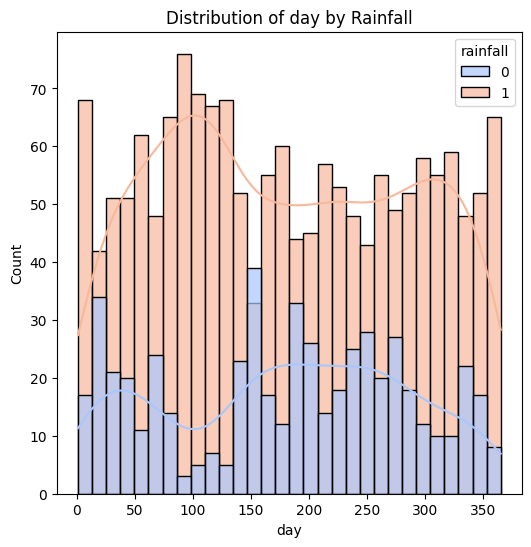

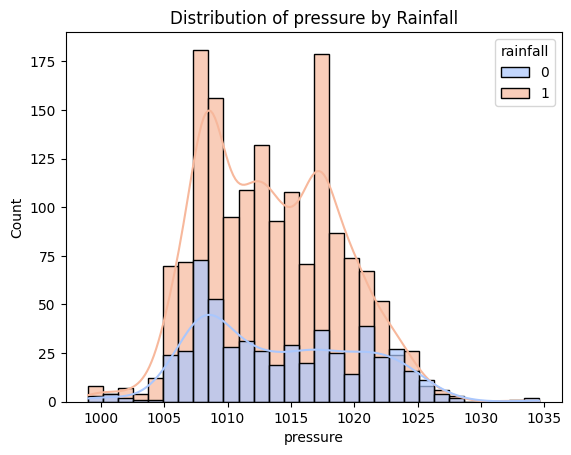

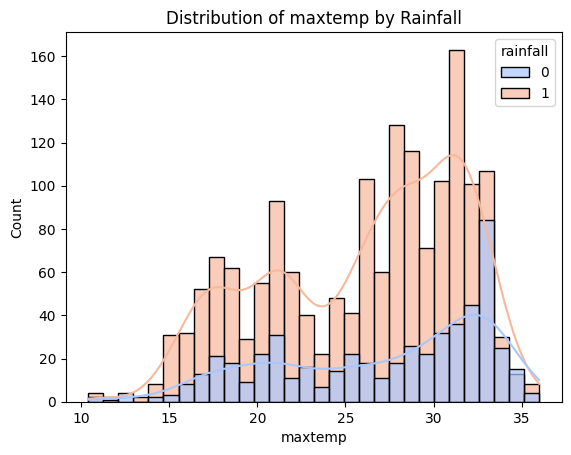

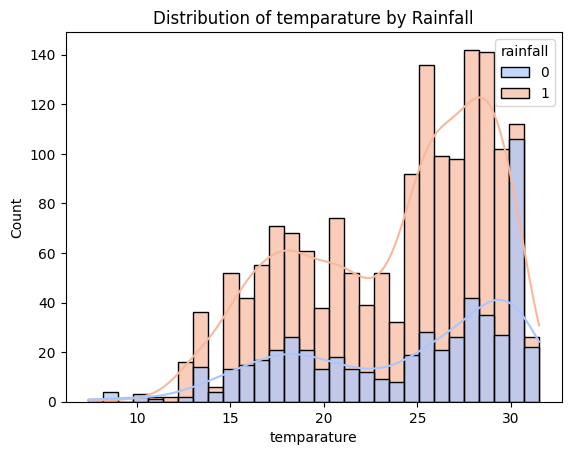

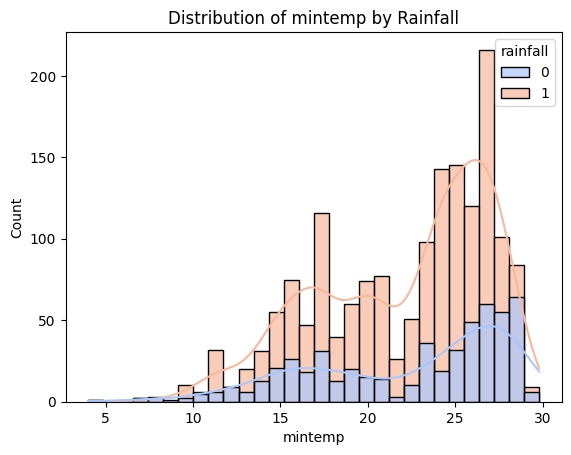

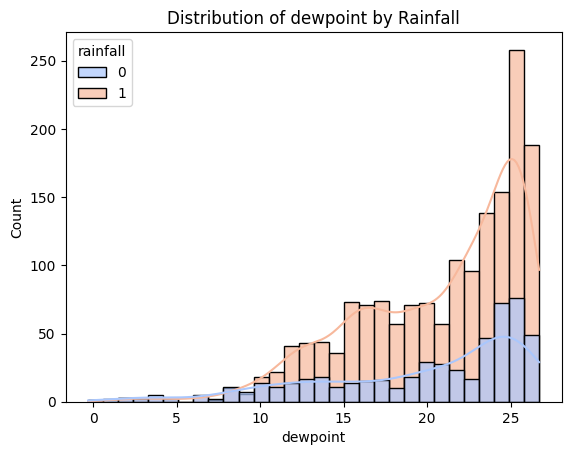

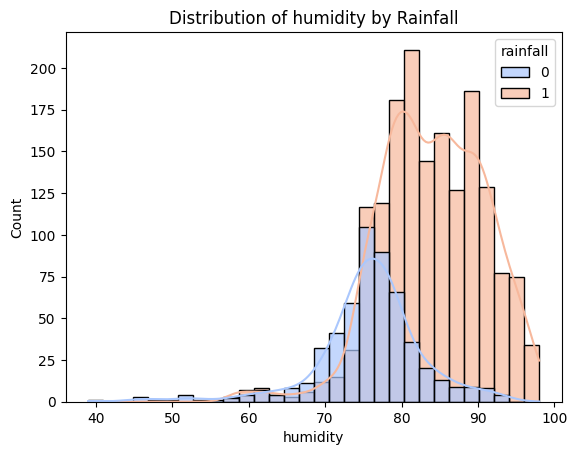

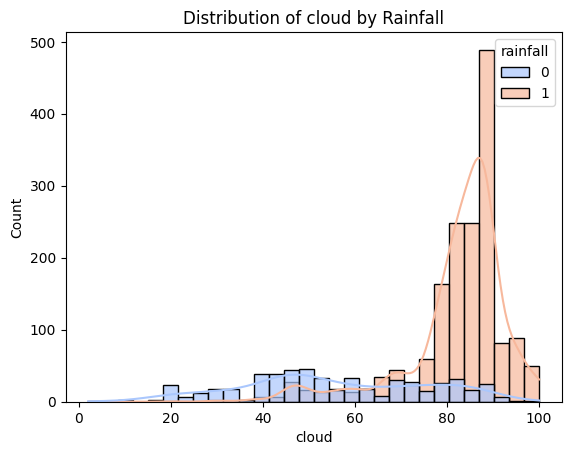

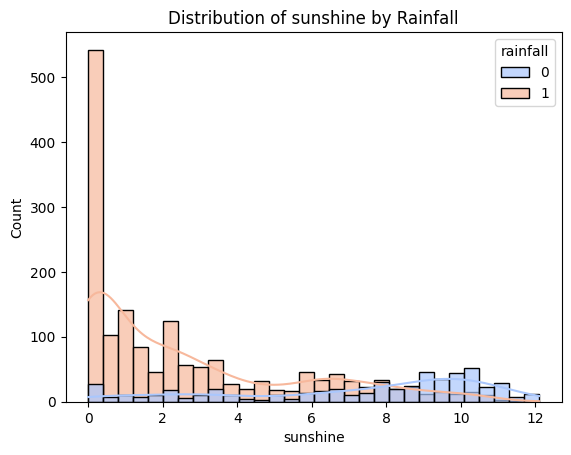

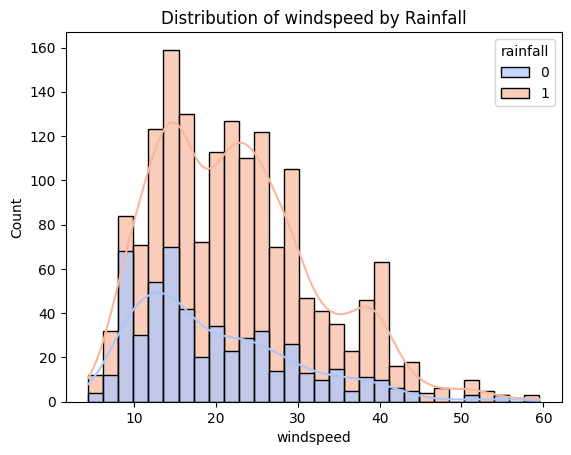

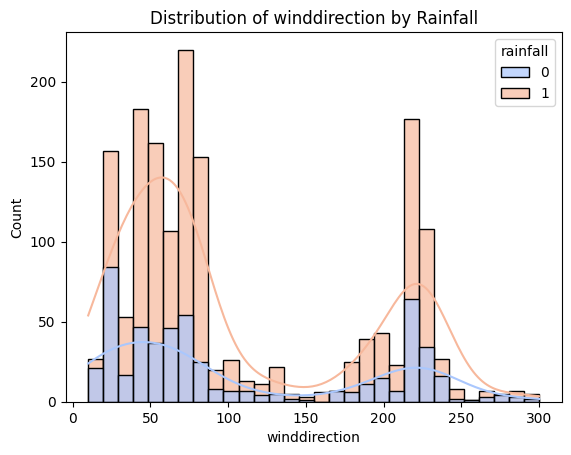

In [ ]:
features = ['day', "pressure", "maxtemp", "temparature", "mintemp", "dewpoint",
            "humidity", "cloud", "sunshine", "windspeed", 'winddirection']

# Set the figure size
plt.figure(figsize=(6, 6))

# Create subplots for each feature
for i, feature in enumerate(features, 1):
    # plt.subplot(3, 3, i)
    sns.histplot(data=train, x=feature, hue="rainfall", kde=True, bins=30, palette="coolwarm", alpha=0.7)
    plt.title(f"Distribution of {feature} by Rainfall")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

In [ ]:
train.select_dtypes(['bool','float', 'int']).corr()[['rainfall']]

,rainfall
day,-0.000462
pressure,-0.049886
maxtemp,-0.079304
temparature,-0.049660
mintemp,-0.026841
dewpoint,0.081965
humidity,0.454213
cloud,0.641191
sunshine,-0.555287
winddirection,-0.006939


In [ ]:
corr_matrix = train.select_dtypes(['bool', 'float', 'int']).corr().abs()

# Get features highly correlated with each other (correlation > 0.7)
upper_triangle = np.triu(corr_matrix, k=1)
high_corr_features = [column for i, column in enumerate(corr_matrix.columns) if any(upper_triangle[:, i] > 0.7)]

# Find correlation of each feature with 'rainfall'
rainfall_corr = corr_matrix["rainfall"].drop("rainfall", errors="ignore")

# Dictionary to store the best feature per correlated group
keep_features = set()

# Iterate through high-correlation pairs and keep only the most correlated with 'rainfall'
for feature in high_corr_features:
    # Check correlation with 'rainfall'
    if feature in rainfall_corr:
        keep_features.add(rainfall_corr.idxmax())  # Keep the feature with highest correlation to rainfall

# Features to drop: all highly correlated features except the selected ones
drop_features = set(high_corr_features) - keep_features
list(drop_features)

['month',
 'relative_sunshine',
 'mintemp',
 'temparature',
 'maxtemp',
 'dewpoint',
 'temp_avg_3d',
 'sunshine']

In [ ]:
train.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425,6.425114
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116,3.441823
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000,1.000000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000,3.000000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000,6.000000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000,9.000000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000,12.000000


In [ ]:
test.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,month
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000,730.000000
mean,183.000000,1013.503014,26.372466,23.963288,22.110274,20.460137,82.669863,76.360274,3.664384,103.923182,22.484247,6.526027
std,105.438271,5.505871,5.672521,5.278098,5.170744,5.391169,7.818714,17.934121,3.639272,81.695458,9.954779,3.450215
min,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000,1.000000
25%,92.000000,1008.725000,21.600000,19.825000,17.825000,16.800000,77.250000,69.000000,0.325000,40.000000,14.500000,4.000000
50%,183.000000,1012.700000,27.800000,25.650000,23.900000,22.300000,82.000000,83.000000,2.200000,70.000000,21.300000,7.000000
75%,274.000000,1017.600000,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000,10.000000
max,365.000000,1032.200000,35.800000,31.800000,29.100000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000,12.000000


In [ ]:
train#[train['humidity'] > 90]#.rainfall.value_counts()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,month
id,,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,12
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,12
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,12


## XGB Model
default: 0.8782 Score: 0.83641 <br>
hyp tune many feats: 0.8893 Score: 0.83748

In [ ]:
# final_results_df = pd.DataFrame(columns=[ 'hyperparameters', 'roc_auc', 'features_used'])

final_results_df = pd.read_csv('/content/drive/MyDrive/Output/Hyperparams/xgb.csv')

In [ ]:
target = 'rainfall'
X = train.drop(columns=[target])  # Features
y = train[target]  # Target

cat_cols = ['season', 'cloud_category', 'wind_direction_category']
X[cat_cols] = X[cat_cols].astype('category')

In [ ]:
# columns = [
#     'day',
#            'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
#        'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
#     # 'month',
#        'season', 'temp_range', 'dewpoint_diff', 'cloud_category',
#        'relative_sunshine', 'wind_direction_category',
#        'humidity_dewpoint_ratio'
#        ]

# columns = ['month',
#  'relative_sunshine',
#  'mintemp',
#  'sunshine',
#  'maxtemp',
#  'temparature',
#  'dewpoint']

# X = X.drop(columns = columns)

In [ ]:
# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=False)  # Adjust shuffle if needed

In [ ]:
# Store out-of-fold (OOF) predictions and fold scores
oof_preds = np.zeros(len(train))
xgb_fold_scores = []

# XGBoost parameters
xgb_params = {'learning_rate': 0.012947427963898379,
    'max_depth': 6,
               'subsample': 0.5036352433598026, 'colsample_bytree': 0.8063317676126651,
               'n_estimators': 158, 'reg_alpha': 2.402528320183448e-05, 'reg_lambda': 3.647412895213917e-05,
    "random_state": 30
}

features_used = list(X.columns)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(**xgb_params, enable_categorical=True)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    fold_pred = model.predict_proba(X_val)[:, 1]  # Probability of class 1
    oof_preds[val_idx] = fold_pred

    # Compute AUC for the fold
    fold_auc = roc_auc_score(y_val, fold_pred)
    xgb_fold_scores.append(fold_auc)
    print(f"Fold {fold+1} AUC: {fold_auc:.4f}")

# Compute overall AUC score
overall_auc = roc_auc_score(y, oof_preds)
print("\nFold AUC Scores:", xgb_fold_scores)
print(f"Overall AUC Score: {overall_auc:.4f}")

Training fold 1...
Fold 1 AUC: 0.8508
Training fold 2...
Fold 2 AUC: 0.9091
Training fold 3...
Fold 3 AUC: 0.9183
Training fold 4...
Fold 4 AUC: 0.8949
Training fold 5...
Fold 5 AUC: 0.8807
Training fold 6...
Fold 6 AUC: 0.8820

Fold AUC Scores: [np.float64(0.850839219260272), np.float64(0.9091313131313132), np.float64(0.9183270082226438), np.float64(0.8949225956525226), np.float64(0.8806790425012213), np.float64(0.8819798088090771)]
Overall AUC Score: 0.8876


In [ ]:
overall_result = {
    'hyperparameters': str(xgb_params),
    'roc_auc': overall_auc,
    'features_used': str(features_used)
}
final_results_df = pd.concat([final_results_df , pd.DataFrame([overall_result])], ignore_index=True)
final_results_df.drop_duplicates(inplace = True)

# Save to CSV
final_results_df.to_csv('/content/drive/MyDrive/Output/Hyperparams/xgb.csv', index=False)

final_results_df

,hyperparameters,roc_auc,features_used
0,"{'learning_rate': 0.022606362383913763, 'max_d...",0.889515,"['day', 'pressure', 'maxtemp', 'temparature', ..."
1,"{'learning_rate': 0.022606362383913763, 'max_d...",0.886550,"['cloud_category', 'cloud', 'relative_sunshine..."
2,"{'objective': 'binary:logistic', 'eval_metric'...",0.888035,"['day', 'pressure', 'humidity', 'cloud', 'wind..."
3,"{'objective': 'binary:logistic', 'eval_metric'...",0.888035,"['day', 'pressure', 'humidity', 'cloud', 'wind..."
4,"{'objective': 'binary:logistic', 'eval_metric'...",0.889515,"['day', 'pressure', 'maxtemp', 'temparature', ..."
5,"{'objective': 'binary:logistic', 'eval_metric'...",0.885018,"['day', 'pressure', 'humidity', 'cloud', 'wind..."
6,"{'objective': 'binary:logistic', 'eval_metric'...",0.887081,"['day', 'pressure', 'maxtemp', 'temparature', ..."
7,"{'objective': 'binary:logistic', 'eval_metric'...",0.886314,"['day', 'pressure', 'maxtemp', 'temparature', ..."
8,"{'objective': 'binary:logistic', 'eval_metric'...",0.887643,"['day', 'pressure', 'maxtemp', 'temparature', ..."


Training fold 1...
Fold 1 AUC: 0.8577
Training fold 2...
Fold 2 AUC: 0.8728
Training fold 3...
Fold 3 AUC: 0.8903
Training fold 4...
Fold 4 AUC: 0.8741
Training fold 5...
Fold 5 AUC: 0.8782

Fold AUC Scores: [0.8577160493827161, 0.8727833894500561, 0.8902637485970819, 0.8740740740740742, 0.8781986531986531]
Overall AUC Score: 0.8752

In [ ]:
feature_importance = model.get_booster().get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame(
    list(feature_importance.items()), columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

importance_df#['Feature'].iloc[:10].values

,Feature,Importance
15,cloud_category,44.350082
7,cloud,40.252785
6,humidity,8.738038
16,relative_sunshine,6.390941
22,temp_avg_3d,6.222103
8,sunshine,5.940371
5,dewpoint,5.239636
3,temparature,4.868018
14,dewpoint_diff,4.360264
4,mintemp,4.154626


#### FFF Select

In [ ]:
# XGBoost parameters
xgb_params = {
    'learning_rate': 0.012947427963898379,
    'max_depth': 6,
    'subsample': 0.5036352433598026,
    'colsample_bytree': 0.8063317676126651,
    'n_estimators': 158,
    'reg_alpha': 2.402528320183448e-05,
    'reg_lambda': 3.647412895213917e-05,
    "random_state": 30
}

# Set up Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Available features
all_features = list(X.columns)
selected_features = []  # Start with no features
best_auc = 0.0  # Track the best AUC score
feature_performance = {}  # Store AUC scores per feature

print("Starting Greedy Forward Feature Selection...\n")

while True:
    best_feature = None
    best_feature_auc = best_auc

    for feature in all_features:
        if feature in selected_features:
            continue  # Skip if already selected

        current_features = selected_features + [feature]
        oof_preds = np.zeros(len(X))  # Store OOF predictions
        fold_scores = []

        # Perform cross-validation
        for fold, (train_idx, val_idx) in enumerate(kf.split(X[current_features], y)):
            X_train, X_val = X[current_features].iloc[train_idx], X[current_features].iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = xgb.XGBClassifier(**xgb_params, enable_categorical=True)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

            fold_pred = model.predict_proba(X_val)[:, 1]  # Probability of class 1
            oof_preds[val_idx] = fold_pred

            # Compute AUC for the fold
            fold_auc = roc_auc_score(y_val, fold_pred)
            fold_scores.append(fold_auc)

        # Compute overall AUC score for this feature
        overall_auc = roc_auc_score(y, oof_preds)
        feature_performance[feature] = overall_auc

        print(f"Feature '{feature}' -> AUC: {overall_auc:.4f}")

        # Update the best feature if AUC improves
        if overall_auc > best_feature_auc:
            best_feature = feature
            best_feature_auc = overall_auc

    # If no feature improves AUC, stop
    if best_feature is None or best_feature_auc <= best_auc:
        print("\nNo further improvement. Stopping feature selection.")
        break

    # Add the best feature to the selection
    selected_features.append(best_feature)
    best_auc = best_feature_auc
    print(f"Selected '{best_feature}', New Best AUC: {best_auc:.4f}\n")

print("\nFinal Selected Features:", selected_features)
print(f"Final AUC Score: {best_auc:.4f}")

Starting Greedy Forward Feature Selection...

Feature 'day' -> AUC: 0.6874
Feature 'pressure' -> AUC: 0.5662
Feature 'maxtemp' -> AUC: 0.5900
Feature 'temparature' -> AUC: 0.5809
Feature 'mintemp' -> AUC: 0.5836
Feature 'dewpoint' -> AUC: 0.5675
Feature 'humidity' -> AUC: 0.8140
Feature 'cloud' -> AUC: 0.8670
Feature 'sunshine' -> AUC: 0.8322
Feature 'winddirection' -> AUC: 0.5649
Feature 'windspeed' -> AUC: 0.5571
Feature 'month' -> AUC: 0.5841
Feature 'season' -> AUC: 0.5453
Feature 'temp_range' -> AUC: 0.6282
Feature 'dewpoint_diff' -> AUC: 0.7337
Feature 'cloud_category' -> AUC: 0.7977
Feature 'relative_sunshine' -> AUC: 0.8313
Feature 'wind_direction_category' -> AUC: 0.5348
Feature 'humidity_dewpoint_ratio' -> AUC: 0.6474
Feature 'pressure_change' -> AUC: 0.5415
Feature 'humidity_change' -> AUC: 0.6481
Feature 'wind_change' -> AUC: 0.5019
Feature 'temp_avg_3d' -> AUC: 0.5584
Feature 'humidity_avg_7d' -> AUC: 0.6654
Selected 'cloud', New Best AUC: 0.8670

Feature 'day' -> AUC: 0.8

In [ ]:
X = X[['day', 'cloud', 'humidity', 'wind_direction_category', 'humidity_dewpoint_ratio', 'humidity_change', 'dewpoint_diff']]

#### Hyp tune

In [ ]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10.0),
        "random_state": 30,
        "use_label_encoder": False
    }

    n_splits = train.shape[0] // 365  # Ensure total_rows is defined
    kf = KFold(n_splits=n_splits, shuffle=False)  # Adjust shuffle if needed
    oof_preds = np.zeros(len(y))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params, enable_categorical=True)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        fold_pred = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = fold_pred

    return roc_auc_score(y, oof_preds)

# Run Optuna hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params = study.best_params

[I 2025-03-18 00:33:28,955] A new study created in memory with name: no-name-01028d36-83c7-42b2-88da-ddd99f939f28
<ipython-input-48-1ecd14375e47>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-48-1ecd14375e47>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10.0),
<ipython-input-48-1ecd14375e47>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.sug

In [ ]:
print("\nBest Hyperparameters:", best_params)
# Train final model using the best parameters
oof_preds = np.zeros(len(y))
xgb_fold_scores = []

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=30)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(**best_params, enable_categorical=True)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    fold_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = fold_pred

    fold_auc = roc_auc_score(y_val, fold_pred)
    xgb_fold_scores.append(fold_auc)
    print(f"Fold {fold+1} AUC: {fold_auc:.4f}")

# Compute overall AUC
overall_auc = roc_auc_score(y, oof_preds)
print("\nFold AUC Scores:", xgb_fold_scores)
print(f"Overall AUC Score: {overall_auc:.4f}")


Best Hyperparameters: {'learning_rate': 0.011387692211788916, 'max_depth': 5, 'subsample': 0.7151623716458795, 'colsample_bytree': 0.6214892043142936, 'n_estimators': 223, 'reg_alpha': 0.0021811865431397713, 'reg_lambda': 0.020144074749710864}
Training fold 1...
Fold 1 AUC: 0.9226
Training fold 2...
Fold 2 AUC: 0.8482
Training fold 3...
Fold 3 AUC: 0.8762
Training fold 4...
Fold 4 AUC: 0.9080
Training fold 5...
Fold 5 AUC: 0.8924

Fold AUC Scores: [np.float64(0.9225589225589226), np.float64(0.8481762065095397), np.float64(0.8762345679012346), np.float64(0.9079685746352413), np.float64(0.8924242424242425)]
Overall AUC Score: 0.8880


In [ ]:
cat_cols = ['season', 'cloud_category', 'wind_direction_category']
test[cat_cols] = test[cat_cols].astype('category')
xgb_pred = model.predict_proba(test[list(X.columns)])[:, 1]
sub['rainfall'] = xgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e3 -f /content/drive/MyDrive/Output/sub.csv -m "xgb fff"

100% 11.0k/11.0k [00:00<00:00, 16.5kB/s]
Successfully submitted to Binary Prediction with a Rainfall Dataset

## HGB
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html <br>


1.   base 0.8895
2.   Hyp tune 0.8910

In [ ]:
target = 'rainfall'
X = train.drop(columns=[target])  # Features
y = train[target]  # Target

cat_cols = ['season', 'cloud_category', 'wind_direction_category']
X[cat_cols] = X[cat_cols].astype('category')

# n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=False)

In [ ]:
# Define categorical and numerical columns
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = ['season', 'cloud_category', 'wind_direction_category']

# Define Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
        ('scaler', StandardScaler())  # Scale numerical features
    ]), num_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
    ]), cat_cols)
])

# Define HistGradientBoosting parameters
hgb_params = {'learning_rate': 0.01975754897540633, 'max_iter': 339,
              'max_leaf_nodes': 10, 'max_depth': 2, 'min_samples_leaf': 5,
              'l2_regularization': 8.119745137775674, 'max_features': 0.3537852698830975, 'max_bins': 79,
              'validation_fraction': 0.28171841528577324, 'n_iter_no_change': 18, 'tol': 3.9644697347513426e-08,
              'random_state': 30}

# Define full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess data
    ('model', HistGradientBoostingClassifier( **hgb_params))  # Train model
])

# Store out-of-fold (OOF) predictions
oof_preds = np.zeros(len(train))
hgb_fold_scores = []

# Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Predict probabilities for class 1
    fold_pred = pipeline.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = fold_pred

    # Compute AUC for the fold
    fold_auc = roc_auc_score(y_val, fold_pred)
    hgb_fold_scores.append(fold_auc)
    print(f"Fold {fold+1} AUC: {fold_auc:.4f}")

# Compute overall AUC score
overall_auc = roc_auc_score(y, oof_preds)
print("\nFold AUC Scores:", hgb_fold_scores)
print(f"Overall AUC Score: {overall_auc:.4f}")

Training fold 1...
Fold 1 AUC: 0.8549
Training fold 2...
Fold 2 AUC: 0.9123
Training fold 3...
Fold 3 AUC: 0.9223
Training fold 4...
Fold 4 AUC: 0.8934
Training fold 5...
Fold 5 AUC: 0.8778
Training fold 6...
Fold 6 AUC: 0.8829

Fold AUC Scores: [np.float64(0.8549024075339865), np.float64(0.9122828282828283), np.float64(0.922280202403542), np.float64(0.8933985722306891), np.float64(0.8777886337730012), np.float64(0.8828732243366391)]
Overall AUC Score: 0.8881


In [ ]:
cat_cols = ['season', 'cloud_category', 'wind_direction_category']
test[cat_cols] = test[cat_cols].astype('category')
hgb_pred = pipeline.predict_proba(test[list(X.columns)])[:, 1]
sub['rainfall'] = hgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e3 -f /content/drive/MyDrive/Output/sub.csv -m "no shuffle"

100% 17.1k/17.1k [00:00<00:00, 25.5kB/s]
Successfully submitted to Binary Prediction with a Rainfall Dataset

#### Hyp Tune

In [ ]:
def objective(trial):
    params = {
        'loss': 'log_loss',  # Fixed loss function
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 10.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'max_bins': trial.suggest_int('max_bins', 50, 255),
        'early_stopping': 'auto',  # Keeping default for auto stopping
        'scoring': 'loss',  # Using loss function for optimization
        'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.3),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'tol': trial.suggest_float('tol', 1e-8, 1e-5, log=True),
        'random_state': 30
    }

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', HistGradientBoostingClassifier(**params))
    ])

    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc', n_jobs=-1)
    return np.mean(scores)

# Run Optuna study
study = optuna.create_study(direction="maximize")  # Maximize AUC Score
study.optimize(objective, n_trials=50, n_jobs=-1)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-17 23:57:18,884] A new study created in memory with name: no-name-826eaf42-f0aa-4de0-9f2c-c392ad2212b1
[I 2025-03-17 23:57:45,714] Trial 1 finished with value: 0.873126488982977 and parameters: {'learning_rate': 0.03170662286654216, 'max_iter': 623, 'max_leaf_nodes': 50, 'max_depth': 13, 'min_samples_leaf': 21, 'l2_regularization': 2.7898601350522734, 'max_features': 0.8383961787969754, 'max_bins': 159, 'validation_fraction': 0.11652796270786826, 'n_iter_no_change': 5, 'tol': 3.987978608788009e-08}. Best is trial 1 with value: 0.873126488982977.
[I 2025-03-17 23:57:49,368] Trial 0 finished with value: 0.8648717774545194 and parameters: {'learning_rate': 0.12403845443834656, 'max_iter': 914, 'max_leaf_nodes': 67, 'max_depth': 5, 'min_samples_leaf': 32, 'l2_regularization': 6.7139489203723555, 'max_features': 0.27304680350920385, 'max_bins': 97, 'validation_fraction': 0.22091838348419807, 'n_iter_no_change': 19, 'tol': 3.6084906389471875e-08}. Best is trial 1 with value: 0.873

Best Hyperparameters: {'learning_rate': 0.01975754897540633, 'max_iter': 339, 'max_leaf_nodes': 10, 'max_depth': 2, 'min_samples_leaf': 5, 'l2_regularization': 8.119745137775674, 'max_features': 0.3537852698830975, 'max_bins': 79, 'validation_fraction': 0.28171841528577324, 'n_iter_no_change': 18, 'tol': 3.9644697347513426e-08}


In [ ]:
# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'learning_rate': 0.01975754897540633, 'max_iter': 339, 'max_leaf_nodes': 10, 'max_depth': 2, 'min_samples_leaf': 5, 'l2_regularization': 8.119745137775674, 'max_features': 0.3537852698830975, 'max_bins': 79, 'validation_fraction': 0.28171841528577324, 'n_iter_no_change': 18, 'tol': 3.9644697347513426e-08}


## Tensorflow

In [ ]:
# ✅ Feature Definitions
target = 'rainfall'
X = train.drop(columns=[target])  # Features
y = train[target]  # Target

num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = ['season', 'cloud_category', 'wind_direction_category']

# ✅ Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]), cat_cols)
])

# ✅ Convert data
X_processed = preprocessor.fit_transform(X)

# ✅ Function to Create Model
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(X_processed.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")  # Binary classification
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["AUC"]
    )

    return model



In [ ]:
# ✅ Stratified K-Fold Training
n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=False)
tf_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_processed, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = build_model()

    # ✅ Early Stopping for Fold Training
    early_stopping = callbacks.EarlyStopping(
        monitor="val_auc", patience=5, mode="max", restore_best_weights=True, verbose=1
    )

    # Fit model
    model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping], verbose=1)

    # Evaluate on validation
    _, auc = model.evaluate(X_val, y_val, verbose=0)
    tf_auc_scores.append(auc)
    print(f"Fold {fold+1} AUC: {auc:.4f}")

Training fold 1...
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - AUC: 0.6544 - loss: 0.5722 - val_AUC: 0.8450 - val_loss: 0.4199
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8883 - loss: 0.3445 - val_AUC: 0.8459 - val_loss: 0.4222
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8992 - loss: 0.3255 - val_AUC: 0.8481 - val_loss: 0.4276
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8914 - loss: 0.3299 - val_AUC: 0.8394 - val_loss: 0.4368
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8784 - loss: 0.3567 - val_AUC: 0.8485 - val_loss: 0.4326
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8988 - loss: 0.3232 - val_AUC: 0.8480 - val_loss: 0.4354
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9028 - loss: 0.3202 - val_AUC: 0.8473 - val_loss: 0.4395
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9006 - loss: 0.3190 - val_AUC: 0.8474 - val_loss: 0.4327
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9109 - loss: 0.2995 - val_AUC: 0.8496 - val_loss: 0.4243
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8979 - loss: 0.3216 - v

In [ ]:
# ✅ Compute Overall Performance
print("\nFold AUC Scores:", tf_auc_scores)
print(f"Overall AUC Score: {np.mean(tf_auc_scores):.4f}")


Fold AUC Scores: [0.8283017873764038, 0.9000808000564575, 0.8892512917518616, 0.8887863755226135, 0.8780532479286194, 0.8850844502449036]
Overall AUC Score: 0.8783


In [ ]:
# ✅ Train Final Model on Full Data with Early Stopping
final_model = build_model()
final_early_stopping = callbacks.EarlyStopping(
    monitor="auc", patience=5, mode="max", restore_best_weights=True, verbose=1
)

final_model.fit(X_processed, y, epochs=100, batch_size=32,
                callbacks=[final_early_stopping], verbose=1)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7216 - loss: 0.4916
Epoch 2/100
57/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8982 - loss: 0.3275

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `auc` which is not available. Available metrics are: AUC,loss
  current = self.get_monitor_value(logs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8937 - loss: 0.3340
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8891 - loss: 0.3482
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8703 - loss: 0.3641
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8961 - loss: 0.3215
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8868 - loss: 0.3527
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9032 - loss: 0.3299
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9061 - loss: 0.3202
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8997 - loss: 0.3235
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8984 - loss: 0.3361
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8954 - loss: 0.3206
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9068 - loss: 0.3115
Epoch 13/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8960 - loss: 0.3224
Epoch 14/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

In [ ]:
cat_cols = ['season', 'cloud_category', 'wind_direction_category']
test[cat_cols] = test[cat_cols].astype('category')
X_processed_test = preprocessor.transform(test)
tf_pred = final_model.predict(X_processed_test)
sub['rainfall'] = tf_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e3 -f /content/drive/MyDrive/Output/sub.csv -m "TF model"

100% 11.1k/11.1k [00:00<00:00, 17.7kB/s]
Successfully submitted to Binary Prediction with a Rainfall Dataset

## Ensemble

In [ ]:
weights = [0.3, 0.4, 0.3]  # Example weights
ensemble_probs = (weights[0] * xgb_pred + weights[1] * hgb_pred + weights[2] * tf_pred.flatten())
sub['rainfall'] = ensemble_probs
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
from scipy.stats import rankdata

weights = [0.3, 0.4, 0.3]  # Example weights

# Compute rank-based predictions
ensemble_ranks = (weights[0] * rankdata(xgb_pred) +
                  weights[1] * rankdata(hgb_pred) +
                  weights[2] * rankdata(tf_pred.flatten()))

# Normalize ranks between 0 and 1
sub['rainfall'] = rankdata(ensemble_ranks) / len(sub)

# Save the submission
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index=False)


In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e3 -f /content/drive/MyDrive/Output/sub.csv -m "ensemble weighted model"

100% 17.2k/17.2k [00:00<00:00, 27.5kB/s]
Successfully submitted to Binary Prediction with a Rainfall Dataset

In [ ]:
from sklearn.linear_model import LogisticRegression

# Generate probability predictions for validation set
xgb_probs = xgb_model.predict_proba(X_val_processed)[:, 1].reshape(-1, 1)
hgb_probs = hbgb_model.predict_proba(X_val_processed)[:, 1].reshape(-1, 1)
tf_probs = tf_model.predict(X_val_processed).flatten().reshape(-1, 1)  # Ensure it's a 1D array

# Stack the probability features for meta-model training
stacked_features = np.hstack((xgb_probs, hgb_probs, tf_probs))

# Train a meta-model (logistic regression is common for stacking)
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_val)

# Stack test probabilities as input to meta-model
stacked_test_features = np.hstack((xgb_pred, hgb_pred, tf_pred.flatten()))

# Predict final probabilities using the meta-model
final_probs = meta_model.predict_proba(stacked_test_features)[:, 1]

## AutoML Model
Base: 0.894955	Score: 0.85921
2. 0.896071	Score: 0.85706
3. 0.895291	Score: 0.85840
4. month dropped 0.895291, Score: 0.85867

In [ ]:
label = 'rainfall'
metric = 'roc_auc'
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric).fit(train.drop('month', axis = 1), auto_stack=True,excluded_model_types=excluded_model_types,
                                                            time_limit=time_limit, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20250304_022752"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.84 GB / 12.67 GB (77.7%)
Disk Space Avail:   71.17 GB / 107.72 GB (66.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.895291,roc_auc,0.605337,270.694793,0.001220,0.207846,2,True,13
1,CatBoost_r177_BAG_L1,0.892507,roc_auc,0.012310,31.088732,0.012310,31.088732,1,True,12
2,CatBoost_BAG_L1,0.891594,roc_auc,0.013149,30.963046,0.013149,30.963046,1,True,5
3,NeuralNetTorch_BAG_L1,0.888980,roc_auc,0.110717,91.372340,0.110717,91.372340,1,True,10
4,LightGBMXT_BAG_L1,0.888945,roc_auc,0.059826,31.215399,0.059826,31.215399,1,True,1
5,NeuralNetFastAI_BAG_L1,0.886127,roc_auc,0.376048,65.087097,0.376048,65.087097,1,True,8
6,ExtraTreesEntr_BAG_L1,0.883574,roc_auc,0.188244,1.022602,0.188244,1.022602,1,True,7
7,LightGBM_BAG_L1,0.882645,roc_auc,0.035399,32.447442,0.035399,32.447442,1,True,2
8,ExtraTreesGini_BAG_L1,0.882561,roc_auc,0.270068,1.323748,0.270068,1.323748,1,True,6
9,XGBoost_BAG_L1,0.882087,roc_auc,0.056494,19.528290,0.056494,19.528290,1,True,9


In [ ]:
predictor.feature_importance(train)

Computing feature importance via permutation shuffling for 12 features using 2190 rows with 5 shuffle sets...
	299.54s	= Expected runtime (59.91s per shuffle set)
	39.42s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
cloud,0.167865,0.008831,9.158573e-07,5,0.186048,0.149681
sunshine,0.028050,0.003747,3.729860e-05,5,0.035765,0.020336
dewpoint,0.024044,0.003952,8.452270e-05,5,0.032182,0.015907
humidity,0.017608,0.003364,1.523518e-04,5,0.024534,0.010682
pressure,0.012633,0.002062,8.228292e-05,5,0.016879,0.008386
windspeed,0.012182,0.000845,2.755232e-06,5,0.013921,0.010443
winddirection,0.007968,0.000561,2.938185e-06,5,0.009124,0.006812
mintemp,0.007315,0.000248,1.577009e-07,5,0.007825,0.006805
day,0.006844,0.000434,1.937475e-06,5,0.007738,0.005949
maxtemp,0.006149,0.000586,9.803319e-06,5,0.007356,0.004941


In [ ]:
# Make preds
y_pred = predictor.predict_proba(test,as_multiclass=False)
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e3 -f /content/drive/MyDrive/Output/sub.csv -m "month_feat_engineer"

100% 11.0k/11.0k [00:00<00:00, 53.7kB/s]
Successfully submitted to Binary Prediction with a Rainfall Dataset